In [2]:
import numpy as np
import awkward as ak
import uproot
import src.functions as fn
from pylab import cm
import matplotlib.pyplot as plt
import networkx as nx
import scipy.stats
import os
import random
import src.Network as net
import hist
from hist import Hist
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
import time
from mpl_toolkits.mplot3d import Axes3D
from numba import njit

In [3]:
#filenameBase="/eos/user/c/chpapage/TICL_samples/CloseByDoubleGamma_E100Eta1p62Delta3_CMSSW_12_4_0_upgrade2026_D86_clue3Dv4_ntuples/220701_225846/0000/"

#filename="/eos/user/c/chpapage/TICL_samples/CloseByDoubleGamma_E100Eta1p62Delta3_CMSSW_12_4_0_upgrade2026_D86_clue3Dv4_ntuples/220701_225846/0000/hgcalNtuple_*.root:ana/tracksters"
filenameFull100GeV="/eos/user/c/chpapage/TICL_samples/CloseByDoubleGamma_E100Eta1p62Delta5_CMSSW_12_4_0_upgrade2026_D86_clue3Dv4_ntuples/220701_225928/0000/ntuples.root"
filenameFull50GeV="/eos/user/c/chpapage/TICL_samples/CloseByDoubleGamma_E50Eta1p62Delta5_CMSSW_12_4_0_upgrade2026_D86_clue3Dv4_ntuples/220701_225808/0000/ntuples.root"
filenameFull25GeV="/eos/user/c/chpapage/TICL_samples/CloseByDoubleGamma_E25Eta1p62Delta5_CMSSW_12_4_0_upgrade2026_D86_clue3Dv4_ntuples/220701_225704/0000/ntuples.root"
folder="CloseByDoubleGamma_E50IncVsE25Com_Eta1p62Delta5_CMSSW_12_4_0_upgrade2026_D86_clue3Dv4"
savefigs=False
#file = uproot.open(filename)
#fileFull=uproot.concatenate(filename)
file50=uproot.open(filenameFull100GeV)
file25=uproot.open(filenameFull50GeV)
datasetName="50 GeV data inc(layerCut) vs 25 GeV data com"

In [4]:
tracksters=file25["ana/tracksters"]
vertices_E = tracksters['vertices_energy'].array()
vertices_indexes = tracksters['vertices_indexes'].array()
vertices_x = tracksters['vertices_x'].array()
vertices_y = tracksters['vertices_y'].array()
vertices_z = tracksters['vertices_z'].array()
vertices_layers=tracksters['vertices_layer'].array()
trackster_E=tracksters['raw_energy'].array()
trackster_phi=tracksters['trackster_barycenter_phi'].array()
trackster_eta=tracksters['trackster_barycenter_eta'].array()

tracksters_50=file50["ana/tracksters"]
vertices_E_50 = tracksters_50['vertices_energy'].array()
vertices_indexes_50 = tracksters_50['vertices_indexes'].array()
vertices_x_50 = tracksters_50['vertices_x'].array()
vertices_y_50 = tracksters_50['vertices_y'].array()
vertices_z_50 = tracksters_50['vertices_z'].array()
vertices_layers_50=tracksters_50['vertices_layer'].array()
trackster_E_50=tracksters_50['raw_energy'].array()
trackster_phi_50=tracksters_50['trackster_barycenter_phi'].array()
trackster_eta_50=tracksters_50['trackster_barycenter_eta'].array()


In [35]:
import numpy as np
import awkward as ak
import uproot
from pylab import cm
import matplotlib.pyplot as plt
import networkx as nx

class Network:
    def __init__(self, vertices_indexes, vertices_x,vertices_y,vertices_z,vertices_E):
        self.ind = vertices_indexes
        self.x = vertices_x
        self.y = vertices_y
        self.z = vertices_z
        self.E = vertices_E
        self.wtMode=0
        self.weights=np.empty(len(vertices_indexes))
        
    def setWtMode(self,wtModeVal):
        self.wtMode=wtModeVal
        
    def edgeBuilderNew(self,nEdg=1):
        # Remove that exception for the moment. Not sure if needed.
        #if len(vertices_indexes) <= nEdg:
        #    raise ValueError("Number of attempted connections 'nEdg' cannot exceed the size of the graph")
        # Create matrix of indexes
        indexes = np.stack([ak.to_numpy(self.ind)]*len(self.ind),axis=0)
        # Perform energy filtering. Keep only nodes that have greater energy that the specified node
        enMtrx = np.stack([ak.to_numpy(self.E)]*len(self.E),axis=0)
        energyMask = enMtrx > np.transpose(enMtrx)
        # Calculate euclidean distance between all nodes and apply energy mask
        distMatr = self.euclideanMatrix()
        # Sort each row and keep the indexes of the sorted arrays
        distSort = np.argsort(distMatr,axis=1)
        # Sort the euclidean distance using the indexes from previous step
        energyMaskSorted = energyMask[np.arange(energyMask.shape[0])[:,None], distSort]
        indexesSorted = indexes[np.arange(energyMask.shape[0])[:,None], distSort]
        # Some awkward magic - converts innermost array length from const to var
        indexesSorted = ak.unflatten(ak.flatten(indexesSorted), ak.num(indexesSorted))
        energyMaskSorted = ak.unflatten(ak.flatten(energyMaskSorted), ak.num(energyMaskSorted))
        # Filter nodes that have lower energy and keep nEdg nearest neighbors
        indexesSorted = indexesSorted[energyMaskSorted]
        indexesSorted = indexesSorted[:,:nEdg]
        return ak.cartesian([self.ind, indexesSorted])

    def euclideanMatrix(self):
        ver_x = ak.to_numpy(self.x)
        ver_y = ak.to_numpy(self.y)
        ver_z = ak.to_numpy(self.z)
        #subtract.outer to compute difference in all combinations
        diff_x = np.subtract.outer(ver_x,ver_x)
        diff_y = np.subtract.outer(ver_y,ver_y)
        diff_z = np.subtract.outer(ver_z,ver_z)
        euclidean_matrix = np.sqrt(diff_x**2+diff_y**2+diff_z**2)

        return euclidean_matrix

    def calcWeight(self, id1, id2,n):
        E1 = self.E[id1]
        E2 = self.E[id2]
        dx = self.x[id2]-self.x[id1]
        dy = self.y[id2]-self.y[id1]
        dz = self.z[id2]-self.z[id1]
        dist = np.sqrt(np.power(dx,2)+np.power(dy,2)+np.power(dz,2))
        """
        Default is not weighted
        Method 1: max(E1, E2)
        Method 2: |E1 - E2|
        Method 3: (d)^(-n)
        Method 4: (method 1 or 2)*(method 3)
        """
        weight = 1;
        if(self.wtMode==1):
            weight = max(E1, E2)
        elif(self.wtMode==2):
            weight = np.abs(E1-E2)
        elif(self.wtMode==3):
            weight = np.power(dist,-n)
        elif(self.wtMode==4):
            weight = np.abs(E1-E2)*np.power(dist,-n)
        elif(self.wtMode==5):
            weight = E2
        return weight
    
    def calcWeights(self,nodes,edges,n):
        for edge in edges:
            #cluster1=layerCluster(edge[0])
            #cluster2=layerCluster(edge[1])
            
            #weight=1
            id1=np.where(nodes==edge.to_list()[0])
            id2=np.where(nodes==edge.to_list()[1])
            E1 = self.E[id1]
            E2 = self.E[id2]
            dx = self.x[id2]-self.x[id1]
            dy = self.y[id2]-self.y[id1]
            dz = self.z[id2]-self.z[id1]
            dist = np.sqrt(np.power(dx,2)+np.power(dy,2)+np.power(dz,2))
            """
            Default is not weighted
            Method 1: max(E1, E2)
            Method 2: |E1 - E2|
            Method 3: (d)^(-n)
            Method 4: (method 1 or 2)*(method 3)
            """
            weight = 1;
            if(self.wtMode==1):
                weight = max(E1, E2)
            elif(self.wtMode==2):
                weight = np.abs(E1-E2)
            elif(self.wtMode==3):
                weight = np.power(dist,-n)
            elif(self.wtMode==4):
                weight = np.abs(E1-E2)*np.power(dist,-n)
            elif(self.wtMode==5):
                weight = E2
            
            self.weights[id1]=weight

    def adjM(self,nodes,edges,isDirected=False):
        adj = np.zeros((len(nodes),len(nodes)))
        for edge in edges:
            #cluster1=layerCluster(edge[0])
            #cluster2=layerCluster(edge[1])
            
            #weight=1
            idx0=np.where(nodes==edge.to_list()[0])
            idx1=np.where(nodes==edge.to_list()[1])
            weight=self.calcWeight(idx0,idx1,self.wtMode)
            adj[idx0,idx1] = weight
            self.weights[idx0]=weight
            if(not isDirected):
                adj[idx1,idx0] = weight
        maxVal=adj.max()
        return adj/maxVal

    def centralityEigen(self,nodes,edges,isDirected=False,printStuff=False):
        adj=self.adjM(nodes,edges,isDirected)
        rows,columns= adj.shape
        eigvals,vecr= np.linalg.eig(adj)
        i=np.argmax(np.abs(eigvals)) 
        c_eig= vecr[:,i]
        if(c_eig[0]<0):
            c_eig *=-1
        if(printStuff):
            print(eigvals)
            print(vecr)
        c_eig_real=c_eig.real
        norm=np.linalg.norm(c_eig_real)
        return c_eig_real/norm

    def centralityKatz(self,nodes,edges,isDirected=False,printStuff=False):
        adj=self.adjM(nodes,edges,isDirected)
        rows,columns= adj.shape
        Id=np.identity(rows)
        eigvals,vecr= np.linalg.eig(adj)
        i=np.argmax(np.abs(eigvals)) 
        alpha= 0.9/eigvals[i]
        c_katz=(np.linalg.inv(Id-alpha*adj.T)-Id)@np.ones((rows)).T
        if(printStuff):
            print(eigvals)
            print(vecr)
        c_katz_real=c_katz.real
        norm=np.linalg.norm(c_katz_real)
        return c_katz_real/norm

    def centralityPageRank(self,nodes,edges,df,isDirected=False,printStuff=False):
        adj=self.adjM(nodes,edges,isDirected)
        rows,columns= adj.shape
        m_ones=np.ones((rows,columns))
        m_pr=df*adj+(1-df)*m_ones/rows
        eigvals,vecr= np.linalg.eig(m_pr)
        i=np.argmax(np.abs(eigvals)) 
        c_pr= vecr[:,i]
        if(c_pr[0]<0):
            c_pr *=-1
        if(printStuff):
            print(eigvals)
            print(vecr)
        c_pr_real=c_pr.real
        #norm=np.linalg.norm(c_pr_real)
        return c_pr_real/sum(c_pr_real)

    def nXCentralityEigen(self,nodes,edges,isDirected=False):
        if(isDirected):
            G=nx.DiGraph()
        else:
            G=nx.Graph()
        G.add_edges_from(ak.to_numpy(edges),weights=self.weights)
        G.add_nodes_from(ak.to_numpy(nodes),weights=self.weights)
        centr_d = nx.eigenvector_centrality_numpy(G)
        centr_np = np.array(list(centr_d.items()))
        return centr_np[centr_np[:, 0].argsort()][:,1]

    def nXCentralityKatz(self,nodes,edges,isDirected=False):
        if(isDirected):
            G=nx.DiGraph()
        else:
            G=nx.Graph()
        #print(self.weights)
        edges=edges.to_list()
        edgesWeights=[(edges[i][0],edges[i][1],self.weights[i]) for i in range(len(edges))]
        #print(edgesWeights)
        G.add_weighted_edges_from(edgesWeights)
        
        #G.add_edges_from(ak.to_numpy(edges),weights=self.weights)
        G.add_nodes_from(ak.to_numpy(nodes),weights=self.weights)
        centr_d = nx.katz_centrality_numpy(G,weight='weight')
        centr_np = np.array(list(centr_d.items()))
        return centr_np[centr_np[:, 0].argsort()][:,1]
    
    
    def nXCentralityPageRank(self,nodes,edges,isDirected=False):
        if(isDirected):
            G=nx.DiGraph()
        else:
            G=nx.Graph()
        edges=edges.to_list()
        edgesWeights=[(edges[i][0],edges[i][1],self.weights[i]) for i in range(len(edges))]
        #print(edgesWeights)
        G.add_weighted_edges_from(edgesWeights)
        #G.add_edges_from(ak.to_numpy(edges),weights=self.weights)
        G.add_nodes_from(ak.to_numpy(nodes))
        centr_d = nx.pagerank_numpy(G,weight='weight')
        centr_np = np.array(list(centr_d.items()))
        centr_f=centr_np[centr_np[:, 0].argsort()][:,1]
        return centr_f/sum(centr_f)

    def longestPathSource(self,nodes,edges,centralities,isDirected=False):
        """
        Finds the longest path in the network from the max
        of the stortest path algorithm.
        """
        if(isDirected):
            G=nx.DiGraph()
        else:
            G=nx.Graph()
        G.add_edges_from(ak.to_numpy(edges),weights=self.weights)
        G.add_nodes_from(ak.to_numpy(nodes),weights=self.weights)

        #Highest centrality node
        i_centralityMax=np.argmax(centralities)
        source=nodes[i_centralityMax]
        #Finds the shortest path from the highest centrality to all other nodes
        pathList=nx.shortest_path_length(G,source=source)
        #Takes the max of all paths to find the longest path
        longestShortestPath=max(pathList.values())
        return longestShortestPath

    
    def centralityProfIter(self,neighborsList,centrality):
        for i in range(len(neighborsList)):
            if(neighborsList[i]==0):
                continue
            if(i in self.doneList):
                continue
            else:
                #print(centrality)
                #print(i)
                self.sumCen+=centrality[i]
                self.n+=1
                self.doneList.append(i)
                #print(adjMatrix[i,:])
                self.nextList.append(adjMatrix[i,:])
                #print(nextList)

    def centralityProf(self,adjMatrix,centrality):
        
        self.nextList=[]
        cenProfList=[max(centrality)]
        i_cen_max=np.argmax(centrality)
        self.doneList=[i_cen_max]
        firstList=adjMatrix[i_cen_max]
        self.sumCen=0
        self.n=0
        self.centralityProfIter(firstList,centrality)
        cenProfList.append(self.sumCen/self.n)
        #print(firstList)
        #nextList=adjMatrix[firstList==1.]
        #print(nextList)
        while(len(self.doneList)<adjMatrix.shape[0]):
            loopList=self.nextList
            self.nextList=[]
            #print(j)
            self.sumCen=0
            self.n=0
            #print(loopList)
            for i in loopList:
                #print("loopList= {}".format(loopList))
                #print("i= {}".format(i))
                self.centralityProfIter(i,centrality)
                #print("doneList= {}".format(self.doneList))
                #print(i==1.)
                #print(self.n)

            if self.n!=0:
                cenProfList.append(self.sumCen/self.n)
            #print(loopList==1.)
            #nextList=adjMatrix[loopList==1.]
            
        return cenProfList
    

In [5]:

comCenProfArray=[]
comNVerticesList=[]
N=500
for evt in range(N):
    print(evt)
    for tr in range(min(len(vertices_indexes[evt]),2)):
        #print(tr)
        if(evt==121 and tr==1):
            continue
        v_layers=vertices_layers[evt][tr]
        v_ind=vertices_indexes[evt][tr]
        v_x=vertices_x[evt][tr]
        v_y=vertices_y[evt][tr]
        v_z=vertices_z[evt][tr]
        v_E=vertices_E[evt][tr]
        TrNet=Network(vertices_indexes[evt,tr],vertices_x[evt,tr],vertices_y[evt,tr],
                                 vertices_z[evt,tr],vertices_E[evt,tr])
        edges_1 = TrNet.edgeBuilderNew()
        edges_1 = ak.flatten(edges_1[ak.num(edges_1) > 0].to_list())
        c_nxkatz_undir=TrNet.nXCentralityKatz(vertices_indexes[evt,tr],edges_1,False)
        adjMatrix=TrNet.adjM(vertices_indexes[evt,tr],edges_1)

        cenProfList=TrNet.centralityProf(adjMatrix,c_nxkatz_undir)
        comCenProfArray.append(cenProfList)
        comNVerticesList.append(len(v_ind))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [6]:

incCenProfArray=[]
incNVerticesList=[]
incEnergies=[]
N=500

for evt in range(N):
    for tr in range(min(len(vertices_indexes_50[evt]),2)):
        #incSlice=fn.incompleteTracksters(vertices_layers_50[evt,tr],0.32,0.002)
        incSlice=fn.incompleteTracksters(vertices_layers_50[evt,tr],0.31,0.01)
        #print(incSlice)
        v_ind_inc=vertices_indexes_50[evt,tr][incSlice]
        v_x_inc=vertices_x_50[evt,tr][incSlice]
        v_y_inc=vertices_y_50[evt,tr][incSlice]
        v_z_inc=vertices_z_50[evt,tr][incSlice]
        v_E_inc=vertices_E_50[evt,tr][incSlice]
        incEnergies.append(ak.sum(v_E_inc))
        if(len(v_ind_inc)<2):
            continue
        TrNet=Network(v_ind_inc,v_x_inc,v_y_inc,v_z_inc,v_E_inc)
        edges_1 = TrNet.edgeBuilderNew()
        edges_1 = ak.flatten(edges_1[ak.num(edges_1) > 0].to_list())
        #c_nxpr_undir=TrNet.nXCentralityPageRank(v_ind_inc,edges_1,0.85,False)
        #c_pr_undir=TrNet.centralityPageRank(v_ind_inc,edges_1,0.85,False)
        c_nx_katz_undir=TrNet.nXCentralityKatz(v_ind_inc,edges_1,False)
        #c_nx_eigen_undir=TrNet.nXCentralityEigen(vertices_indexes_com_g[tr],edges_1,False)
        #i_cen_max=np.argmax(c_pr_undir)
        adjMatrix=TrNet.adjM(v_ind_inc,edges_1)

        cenProfList=TrNet.centralityProf(adjMatrix,c_nx_katz_undir)
        incCenProfArray.append(cenProfList)
        incNVerticesList.append(len(v_ind_inc))
        if(len(cenProfList)>len(v_ind_inc)):
            print(cenProfList)
            print(len(v_ind_inc))
            print(evt,tr)
            print(v_ind_inc)
            print(edges_1)
        #print(len(incCenProfArray[i]))
        #print(incNVerticesList[i]-1)



In [ ]:
plt.hist(ak.flatten(ak.sum(vertices_E,axis=-1)[:1000]),histtype='step',bins=15,label="Complete")
plt.hist(incEnergies,histtype='step',bins=20,label="Incomplete")
plt.xlabel("Trackster energy",fontsize=18)
plt.legend()

In [ ]:
plt.hist(comNVerticesList,histtype='step',bins=25,label="Complete")
plt.hist(incNVerticesList,histtype='step',bins=15,label="Incomplete")
plt.xlabel("Number of vertices",fontsize=18)
plt.legend()

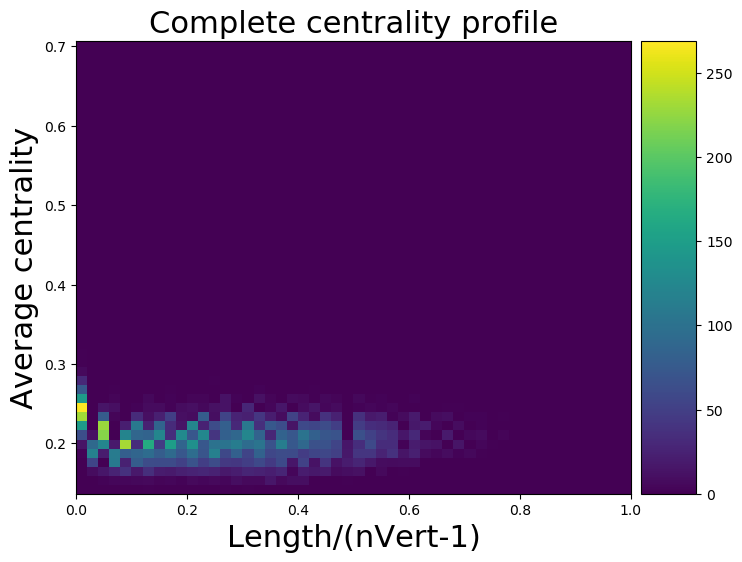

In [7]:


xValues=[]
#print(len(comCenProfArray))
for i in range(len(comCenProfArray)):
    xValues.append(np.arange(0,(len(comCenProfArray[i])))/(comNVerticesList[i]-1))
#print(xValues)
heatmap, xedges, yedges = np.histogram2d([x for xs in xValues for x in xs]
                                         ,[x for xs in comCenProfArray for x in xs],bins=50)

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
fig=plt.figure(figsize=(8,6),dpi=100)
ax=plt.gca()
im=ax.imshow(heatmap.T, extent=extent, origin='lower', aspect='auto')
plt.title("Complete centrality profile",fontsize=22)
plt.xlabel("Length/(nVert-1)",fontsize=22)
plt.ylabel("Average centrality",fontsize=22)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.1)
   
plt.colorbar(im, cax=cax)
plt.show()
#plt.(np.arange(1,len(comCenProfArray[i])+1)/comNVerticesList[i],comCenProfArray[i])


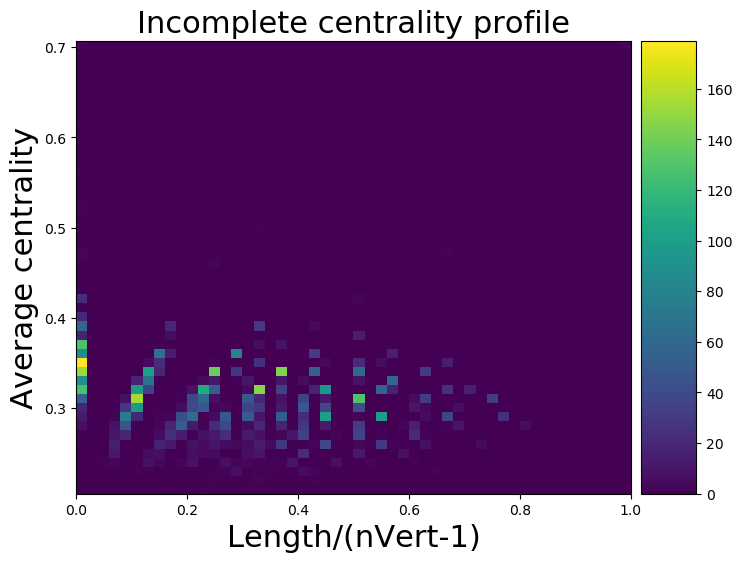

In [8]:


xValues=[]
#print(len(comCenProfArray))
for i in range(len(incCenProfArray)):
    temp=np.arange(0,(len(incCenProfArray[i])))/(incNVerticesList[i]-1)
    if((temp>1).any()):
        print(len(incCenProfArray[i]))
        print(incNVerticesList[i]-1)
    xValues.append(temp)
#print(xValues)
heatmap, xedges, yedges = np.histogram2d([x for xs in xValues for x in xs]
                                         ,[x for xs in incCenProfArray for x in xs],bins=50)



extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
fig=plt.figure(figsize=(8,6),dpi=100)
plt.clf()
ax=plt.gca()
im=ax.imshow(heatmap.T, extent=extent, origin='lower',aspect='auto')
plt.title("Incomplete centrality profile",fontsize=22)
plt.xlabel("Length/(nVert-1)",fontsize=22)
plt.ylabel("Average centrality",fontsize=22)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.1)
   
plt.colorbar(im, cax=cax)
plt.show()
#plt.(np.arange(1,len(comCenProfArray[i])+1)/comNVerticesList[i],comCenProfArray[i])


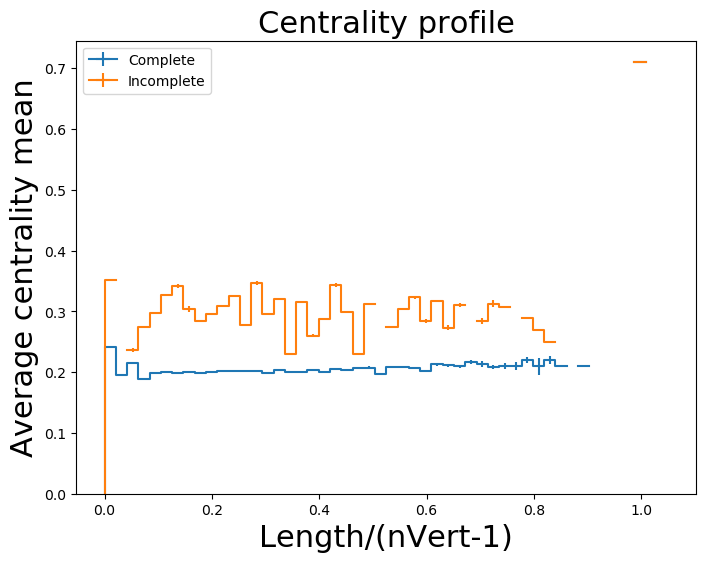

In [9]:


xValues=[]
#print(len(comCenProfArray))
for i in range(len(comCenProfArray)):
    xValues.append(np.arange(0,(len(comCenProfArray[i])))/(comNVerticesList[i]-1))

hCom_xy = hist.Hist(
    hist.axis.Regular(50, 0, 1.05, name="x",overflow="False"), hist.axis.Regular(50, 0, 1, name="y")
).fill(x=[x for xs in xValues for x in xs],y=[x for xs in comCenProfArray for x in xs])
hpCom = hCom_xy.profile("y")


xValues=[]
#print(len(comCenProfArray))
for i in range(len(incCenProfArray)):
    xValues.append(np.arange(0,(len(incCenProfArray[i])))/(incNVerticesList[i]-1))

hInc_xy = hist.Hist(
    hist.axis.Regular(50, 0, 1.05, name="x",overflow="False"), hist.axis.Regular(50, 0, 1, name="y")
).fill(x=[x for xs in xValues for x in xs],y=[x for xs in incCenProfArray for x in xs])
#print(h_xy)
hpInc = hInc_xy.profile("y")
fig=plt.figure(figsize=(8,6),dpi=100)
hpCom.plot(label='Complete')
hpInc.plot(label='Incomplete')
plt.title("Centrality profile",fontsize=22)
plt.xlabel("Length/(nVert-1)",fontsize=22)
plt.ylabel("Average centrality mean",fontsize=22)
plt.legend()
plt.show()


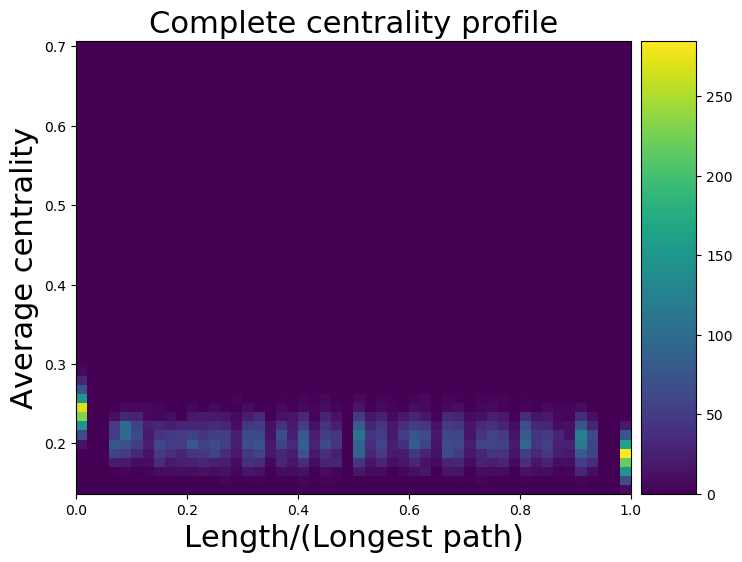

In [10]:


xValues=[]
#print(len(comCenProfArray))
for i in range(len(comCenProfArray)):
    xValues.append(np.arange(0,(len(comCenProfArray[i])))/(len(comCenProfArray[i])-1))
#print(xValues)
heatmap, xedges, yedges = np.histogram2d([x for xs in xValues for x in xs]
                                         ,[x for xs in comCenProfArray for x in xs],bins=50)

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
fig=plt.figure(figsize=(8,6),dpi=100)
ax=plt.gca()
im=ax.imshow(heatmap.T, extent=extent, origin='lower', aspect='auto')
plt.title("Complete centrality profile",fontsize=22)
plt.xlabel("Length/(Longest path)",fontsize=22)
plt.ylabel("Average centrality",fontsize=22)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.1)
   
plt.colorbar(im, cax=cax)
plt.show()
#plt.(np.arange(1,len(comCenProfArray[i])+1)/comNVerticesList[i],comCenProfArray[i])


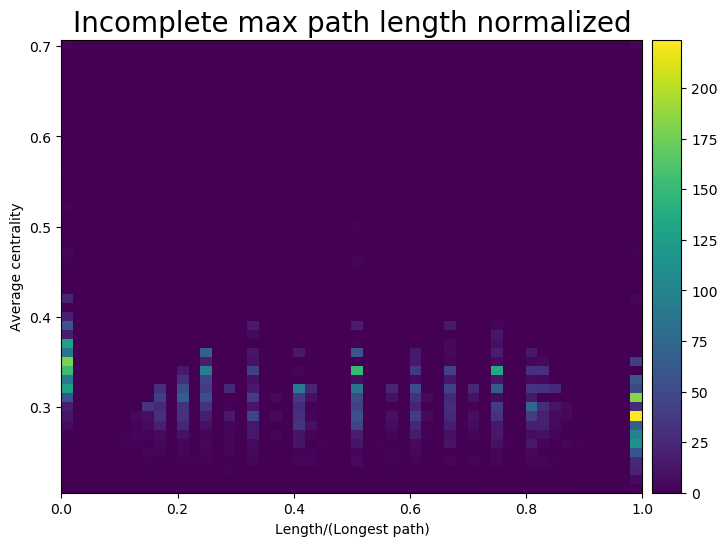

In [11]:


xValues=[]
#print(len(comCenProfArray))
for i in range(len(incCenProfArray)):
    xValues.append(np.arange(0,(len(incCenProfArray[i])))/(len(incCenProfArray[i])-1))
#print(xValues)
heatmap, xedges, yedges = np.histogram2d([x for xs in xValues for x in xs]
                                         ,[x for xs in incCenProfArray for x in xs],bins=50)

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
fig=plt.figure(figsize=(8,6),dpi=100)
plt.clf()
ax=plt.gca()
im=ax.imshow(heatmap.T, extent=extent, origin='lower',aspect='auto')
plt.title("Incomplete max path length normalized",fontsize=20)
plt.xlabel("Length/(Longest path)")
plt.ylabel("Average centrality")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
   
plt.colorbar(im, cax=cax)
plt.show()
#plt.(np.arange(1,len(comCenProfArray[i])+1)/comNVerticesList[i],comCenProfArray[i])


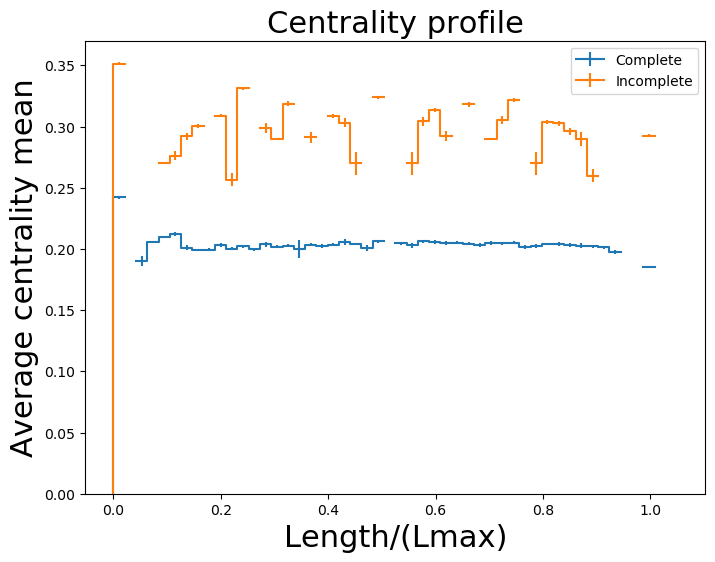

In [12]:


xValues=[]
#print(len(comCenProfArray))
for i in range(len(comCenProfArray)):
    xValues.append(np.arange(0,(len(comCenProfArray[i])))/(len(comCenProfArray[i])-1))

hCom_xy = hist.Hist(
    hist.axis.Regular(50, 0, 1.05, name="x",overflow="False"), hist.axis.Regular(50, 0, 1, name="y")
).fill(x=[x for xs in xValues for x in xs],y=[x for xs in comCenProfArray for x in xs])
hpCom = hCom_xy.profile("y")


xValues=[]
#print(len(comCenProfArray))
for i in range(len(incCenProfArray)):
    xValues.append(np.arange(0,(len(incCenProfArray[i])))/(len(incCenProfArray[i])-1))

hInc_xy = hist.Hist(
    hist.axis.Regular(50, 0, 1.05, name="x",overflow="False"), hist.axis.Regular(50, 0, 1, name="y")
).fill(x=[x for xs in xValues for x in xs],y=[x for xs in incCenProfArray for x in xs])
#print(h_xy)
hpInc = hInc_xy.profile("y")

fig=plt.figure(figsize=(8,6),dpi=100)
hpCom.plot(label='Complete')
hpInc.plot(label='Incomplete')
plt.title("Centrality profile",fontsize=22)
plt.xlabel("Length/(Lmax)",fontsize=22)
plt.ylabel("Average centrality mean",fontsize=22)
plt.legend()
plt.show()

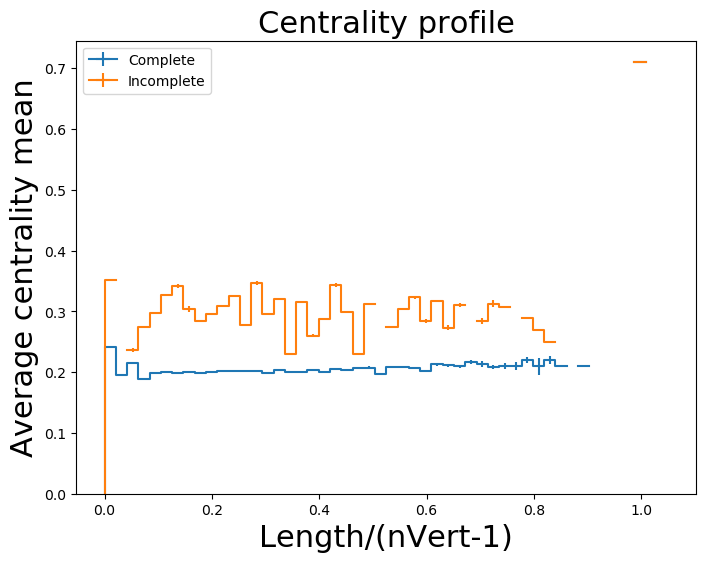

In [13]:


xValues=[]
#print(len(comCenProfArray))
for i in range(len(comCenProfArray)):
    xValues.append(np.arange(0,(len(comCenProfArray[i])))/(comNVerticesList[i]-1))

hCom_xy = hist.Hist(
    hist.axis.Regular(50, 0, 1.05, name="x",overflow="False"), hist.axis.Regular(50, 0, 1, name="y")
).fill(x=[x for xs in xValues for x in xs],y=[x for xs in comCenProfArray for x in xs])
hpCom = hCom_xy.profile("y")


xValues=[]
#print(len(comCenProfArray))
for i in range(len(incCenProfArray)):
    xValues.append(np.arange(0,(len(incCenProfArray[i])))/(incNVerticesList[i]-1))

hInc_xy = hist.Hist(
    hist.axis.Regular(50, 0, 1.05, name="x",overflow="False"), hist.axis.Regular(50, 0, 1, name="y")
).fill(x=[x for xs in xValues for x in xs],y=[x for xs in incCenProfArray for x in xs])
#print(h_xy)
hpInc = hInc_xy.profile("y")
fig=plt.figure(figsize=(8,6),dpi=100)
hpCom.plot(label='Complete')
hpInc.plot(label='Incomplete')
plt.title("Centrality profile",fontsize=22)
plt.xlabel("Length/(nVert-1)",fontsize=22)
plt.ylabel("Average centrality mean",fontsize=22)
plt.legend()
plt.show()

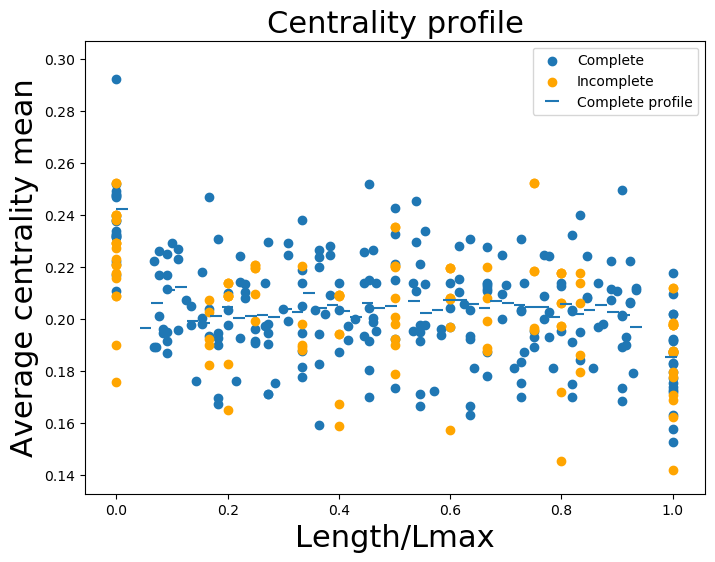

In [131]:
xValues=[]
#print(len(comCenProfArray))
for i in range(len(comCenProfArray[:500])):
    xValues.append(np.arange(0,(len(comCenProfArray[:500][i])))/(len(comCenProfArray[:500][i])-1))

hCom_xy = hist.Hist(
    hist.axis.Regular(50, 0, 1.05, name="x",overflow="False"), hist.axis.Regular(50, 0, 1, name="y")
).fill(x=[x for xs in xValues for x in xs],y=[x for xs in comCenProfArray[:500] for x in xs])
hpCom = hCom_xy.profile("y")
hpComY, hpComXEdges =hpCom.to_numpy()
hpComX=[(hpComXEdges[i]+hpComXEdges[i+1])/2 for i in range(len(hpComXEdges)-1)]

mask=np.logical_not(np.isnan(hpComY))
hpComY=hpComY[mask]
hpComX=np.asarray(hpComX)[mask]

#plt.errorbar(hpComX,hpComY,xerr=(hpComX[5]-hpComX[4])/2,linestyle="none",label="Complete profile")
comYMean=np.mean(hpComY)
N=20
comEvents=np.random.randint(500,990,N)
#print(comEvents)
comTestEvents=np.asarray(comCenProfArray)[comEvents]
#print(comTestEvents)
incEvents=np.random.randint(0,990,N)
incTestEvents=np.asarray(incCenProfArray)[incEvents]
fig=plt.figure(figsize=(8,6),dpi=100)
xValues=[]
for i in range(len(comTestEvents)):
    xValues.append(np.arange(0,(len(comTestEvents[i])))/(len(comTestEvents[i])-1))
comScatterY=[x for xs in comTestEvents for x in xs]
plt.scatter([x for xs in xValues for x in xs],np.asarray(comScatterY)*comYMean/np.mean(comScatterY),color='C0',label="Complete")


#print(incTestEvents)

xValues=[]
for i in range(len(incTestEvents)):
    xValues.append(np.arange(0,(len(incTestEvents[i])))/(len(incTestEvents[i])-1))
incScatterY=[x for xs in incTestEvents for x in xs]
#print(incScatterY)
plt.scatter([x for xs in xValues for x in xs],np.asarray(incScatterY)*comYMean/np.mean(incScatterY),color="orange",label="Incomplete")
#hpCom.plot(label="Complete profile")
plt.errorbar(hpComX,hpComY,xerr=(hpComX[5]-hpComX[4])/2,linestyle="none",label="Complete profile")

plt.title("Centrality profile",fontsize=22)
plt.xlabel("Length/Lmax",fontsize=22)
plt.ylabel("Average centrality mean",fontsize=22)
plt.legend()
#plt.ylim(0,0.3)
plt.show()

In [52]:
incWassenstein=[]
comWassenstein=[]

comProfileY,comProfileXEdges =hpCom.to_numpy()
#comProfileXClearn=comProfileX
print(comProfileXEdges,comProfileY)
comProfileX=[(comProfileXEdges[i]+comProfileXEdges[i+1])/2 for i in range(len(comProfileXEdges)-1)]
print(len(comProfileX),len(comProfileY))

comProfileYFixed=comProfileY[comProfileY > 0]
comProfileX=np.asarray(comProfileX)[comProfileY>0]
print(comProfileYFixed,comProfileX)
for i in range(250):
    incV=np.arange(0,(len(incCenProfArray[i])))/(incNVerticesList[i]-1)
    incWasserstein=scipy.stats.wasserstein_distance(comProfileX,incV
                                                 ,u_weights=comProfileYFixed,v_weights=incCenProfArray[i])
    #print(wassenstein)
    incWassenstein.append(incWasserstein)
    
    comV=np.arange(0,(len(comCenProfArray[500:][i])))/(comNVerticesList[500:][i]-1)
    comWasserstein=scipy.stats.wasserstein_distance(comProfileX,comV
                                                 ,u_weights=comProfileYFixed,v_weights=comCenProfArray[500:][i])
    #print(wassenstein)
    comWassenstein.append(comWasserstein)



[0.    0.021 0.042 0.063 0.084 0.105 0.126 0.147 0.168 0.189 0.21  0.231
 0.252 0.273 0.294 0.315 0.336 0.357 0.378 0.399 0.42  0.441 0.462 0.483
 0.504 0.525 0.546 0.567 0.588 0.609 0.63  0.651 0.672 0.693 0.714 0.735
 0.756 0.777 0.798 0.819 0.84  0.861 0.882 0.903 0.924 0.945 0.966 0.987
 1.008 1.029 1.05 ] [0.24228           nan 0.19666667 0.20619469 0.21128655 0.21244444
 0.19931034 0.19837989 0.20104762 0.20456522 0.20025974 0.20123288
 0.20142857 0.20095238 0.204      0.20272727 0.21       0.20415205
 0.20526316 0.20312821 0.2008     0.20633028 0.20411765 0.20494071
        nan 0.2068254  0.20222222 0.20361111 0.2072043  0.20747899
 0.20596899 0.20442424 0.20714286 0.20631579 0.20545455 0.20448276
 0.20480519 0.20076923 0.20571429 0.20211538 0.20338983 0.20559322
 0.20278689 0.20153285 0.19701754        nan        nan 0.18548
        nan        nan]
50 50
[0.24228    0.19666667 0.20619469 0.21128655 0.21244444 0.19931034
 0.19837989 0.20104762 0.20456522 0.20025974 0.20123288 0.

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
plt.title("Wasserstein",fontsize=20)
plt.hist(comWassenstein,histtype="step",label="Complete")
plt.hist(incWassenstein,histtype="step",label="Incomplete")
plt.legend()

In [ ]:
xValues=[]
#print(len(comCenProfArray))
for i in range(len(comCenProfArray)):
    xValues.append(np.arange(0,(len(comCenProfArray[i])))/(len(comCenProfArray[i])-1))

hCom_xy = hist.Hist(
    hist.axis.Regular(50, 0, 1.05, name="x",overflow="False"), hist.axis.Regular(50, 0, 1, name="y")
).fill(x=[x for xs in xValues for x in xs],y=[x for xs in comCenProfArray for x in xs])
hpCom = hCom_xy.profile("y")


xValues=[]
#print(len(comCenProfArray))
for i in range(len(incCenProfArray)):
    xValues.append(np.arange(0,(len(incCenProfArray[i])))/(len(incCenProfArray[i])-1))

hInc_xy = hist.Hist(
    hist.axis.Regular(50, 0, 1.05, name="x",overflow="False"), hist.axis.Regular(50, 0, 1, name="y")
).fill(x=[x for xs in xValues for x in xs],y=[x for xs in incCenProfArray for x in xs])
#print(h_xy)
hpInc = hInc_xy.profile("y")

fig=plt.figure(figsize=(8,6),dpi=100)
hpCom.plot(label='Complete')
hpInc.plot(label='Incomplete')
plt.title("Centrality profile",fontsize=22)
plt.xlabel("Length/(Lmax)",fontsize=22)
plt.ylabel("Average centrality mean",fontsize=22)
plt.legend()
plt.show()

incWassenstein=[]
comWassenstein=[]

comProfileY,comProfileXEdges =hpCom.to_numpy()
#comProfileXClearn=comProfileX
print(comProfileXEdges,comProfileY)
comProfileX=[(comProfileXEdges[i]+comProfileXEdges[i+1])/2 for i in range(len(comProfileXEdges)-1)]
print(len(comProfileX),len(comProfileY))

comProfileYFixed=comProfileY[comProfileY > 0]
comProfileX=np.asarray(comProfileX)[comProfileY>0]
print(comProfileYFixed,comProfileX)
for i in range(250):
    incV=np.arange(0,(len(incCenProfArray[i])))/(len(incCenProfArray[i])-1)
    incWasserstein=scipy.stats.wasserstein_distance(comProfileX,incV
                                                 ,u_weights=comProfileYFixed,v_weights=incCenProfArray[i])
    #print(wassenstein)
    incWassenstein.append(incWasserstein)
    
    comV=np.arange(0,(len(comCenProfArray[500:][i])))/(len(comCenProfArray[500:][i])-1)
    comWasserstein=scipy.stats.wasserstein_distance(comProfileX,comV
                                                 ,u_weights=comProfileYFixed,v_weights=comCenProfArray[500:][i])
    #print(wassenstein)
    comWassenstein.append(comWasserstein)


plt.title("Wasserstein",fontsize=20)
plt.hist(comWassenstein,histtype="step",bins=30,label="Complete")
plt.hist(incWassenstein,histtype="step",bins=30,label="Incomplete")
plt.legend()

In [ ]:
incMeanMethod=[]
comMeanMethod=[]

comProfileY,comProfileXEdges =hpCom.to_numpy()
#comProfileXClearn=comProfileX
print(comProfileXEdges,comProfileY)
comProfileX=[(comProfileXEdges[i]+comProfileXEdges[i+1])/2 for i in range(len(comProfileXEdges)-1)]
print(len(comProfileX),len(comProfileY))

comProfileYFixed=comProfileY[comProfileY > 0]
comProfileX=np.asarray(comProfileX)[comProfileY>0]
print(comProfileYFixed,comProfileX)
for i in range(490):
    incV=np.arange(0,(len(incCenProfArray[i])))/(incNVerticesList[i]-1)
    
    idx = (np.abs(comProfileX.reshape(len(comProfileX),1) - incV.reshape(1,len(incV)))).argmin(axis=0)
    vals=np.abs(comProfileYFixed[idx]-incCenProfArray[i])
    
    incMeanMethod.append(np.mean(vals))
    
    comV=np.arange(0,(len(comCenProfArray[500:][i])))/(comNVerticesList[500:][i]-1)
    
    idx = (np.abs(comProfileX.reshape(len(comProfileX),1) - comV.reshape(1,len(comV)))).argmin(axis=0)
    vals=np.abs(comProfileYFixed[idx]-comCenProfArray[500:][i])
    #print(vals)
    comMeanMethod.append(np.mean(vals))



In [ ]:
plt.title("Mean distance",fontsize=20)
plt.hist(comMeanMethod,histtype="step",bins=40,label="Complete")
plt.hist(incMeanMethod,histtype="step",bins=40,label="Incomplete")
#plt.xlim(0,0.015)
plt.legend()

In [ ]:

incMeanMethod=[]
comMeanMethod=[]

comProfileY,comProfileXEdges =hpCom.to_numpy()
#comProfileXClearn=comProfileX
print(comProfileXEdges,comProfileY)
comProfileX=[(comProfileXEdges[i]+comProfileXEdges[i+1])/2 for i in range(len(comProfileXEdges)-1)]
print(len(comProfileX),len(comProfileY))

comProfileYFixed=comProfileY[comProfileY > 0]
comProfileX=np.asarray(comProfileX)[comProfileY>0]
print(comProfileYFixed,comProfileX)
for i in range(490):
    incV=np.arange(0,(len(incCenProfArray[i])))/(incNVerticesList[i]-1)
    
    idx = (np.abs(comProfileX.reshape(len(comProfileX),1) - incV.reshape(1,len(incV)))).argmin(axis=0)
    vals=(comProfileYFixed[idx]-incCenProfArray[i])**2
    
    incMeanMethod.append(np.mean(vals))
    
    comV=np.arange(0,(len(comCenProfArray[500:][i])))/(comNVerticesList[500:][i]-1)
    
    idx = (np.abs(comProfileX.reshape(len(comProfileX),1) - comV.reshape(1,len(comV)))).argmin(axis=0)
    vals=(comProfileYFixed[idx]-comCenProfArray[500:][i])**2
    #print(vals)
    comMeanMethod.append(np.mean(vals))



In [ ]:
plt.hist(comMeanMethod,histtype="step",bins=40,label="Complete")
plt.hist(incMeanMethod,histtype="step",bins=40,label="Incomplete")
plt.legend()

In [10]:
file100=uproot.open(filenameFull100GeV)
file50=uproot.open(filenameFull50GeV)
file25=uproot.open(filenameFull25GeV)

tracksters=file25["ana/tracksters"]
vertices_E = tracksters['vertices_energy'].array()
vertices_indexes = tracksters['vertices_indexes'].array()
vertices_x = tracksters['vertices_x'].array()
vertices_y = tracksters['vertices_y'].array()
vertices_z = tracksters['vertices_z'].array()
vertices_layers=tracksters['vertices_layer'].array()

tracksters_50=file50["ana/tracksters"]
vertices_E_50 = tracksters_50['vertices_energy'].array()
vertices_indexes_50 = tracksters_50['vertices_indexes'].array()
vertices_x_50 = tracksters_50['vertices_x'].array()
vertices_y_50 = tracksters_50['vertices_y'].array()
vertices_z_50 = tracksters_50['vertices_z'].array()
vertices_layers_50=tracksters_50['vertices_layer'].array()

tracksters_100=file100["ana/tracksters"]
vertices_E_100 = tracksters_100['vertices_energy'].array()
vertices_indexes_100 = tracksters_100['vertices_indexes'].array()
vertices_x_100 = tracksters_100['vertices_x'].array()
vertices_y_100 = tracksters_100['vertices_y'].array()
vertices_z_100 = tracksters_100['vertices_z'].array()
vertices_layers_100=tracksters_100['vertices_layer'].array()

incNVertices=[]
incEnergies=[]
comEnergies50=[]
comNVertices50=[]
N=500

for evt in range(N):
    for tr in range(min(len(vertices_indexes_50[evt]),2)):
        #incSlice=fn.incompleteTracksters(vertices_layers_50[evt,tr],0.32,0.002)
        incSlice=fn.incompleteTracksters(vertices_layers_50[evt,tr],0.31,0.03)
        #print(incSlice)
        v_ind_inc=vertices_indexes_50[evt,tr][incSlice]
        v_E_inc=vertices_E_50[evt,tr][incSlice]
        incEnergies.append(ak.sum(v_E_inc))
        incNVertices.append(len(v_ind_inc))
        comEnergies50.append(ak.sum(vertices_E_50[evt,tr]))
        comNVertices50.append(len(vertices_indexes_50[evt,tr]))

incEnergies100=[]
incNVertices100=[]
comEnergies100=[]
comNVertices100=[]
for evt in range(N):
    for tr in range(min(len(vertices_indexes_100[evt]),2)):
        #incSlice=fn.incompleteTracksters(vertices_layers_50[evt,tr],0.32,0.002)
        incSlice=fn.incompleteTracksters(vertices_layers_100[evt,tr],0.31,0.03)
        #print(incSlice)
        v_ind_inc=vertices_indexes_100[evt,tr][incSlice]
        v_E_inc=vertices_E_100[evt,tr][incSlice]
        incEnergies100.append(ak.sum(v_E_inc))
        incNVertices100.append(len(v_ind_inc))
        comEnergies100.append(ak.sum(vertices_E_100[evt,tr]))
        comNVertices100.append(len(vertices_indexes_100[evt,tr]))
        
comEnergies25=[]
comNVertices25=[]

for evt in range(N):
    for tr in range(min(len(vertices_indexes[evt]),2)):
        comEnergies25.append(ak.sum(vertices_E[evt,tr]))
        comNVertices25.append(len(vertices_indexes[evt,tr]))

22.474321690515616
45.65875981561281
91.65793158793636
22.11322128082905
45.31695580556802


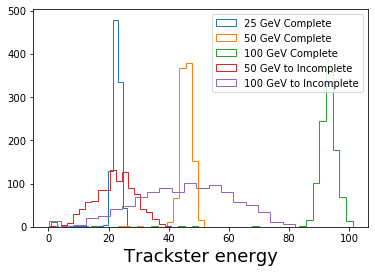

In [11]:
plt.hist(comEnergies25,histtype='step',bins=15,label="25 GeV Complete")
plt.hist(comEnergies50,histtype='step',bins=25,label="50 GeV Complete")
plt.hist(comEnergies100,histtype='step',bins=45,label="100 GeV Complete")
plt.hist(incEnergies,histtype='step',bins=20,label="50 GeV to Incomplete")
plt.hist(incEnergies100,histtype='step',bins=20,label="100 GeV to Incomplete")
plt.xlabel("Trackster energy",fontsize=18)
plt.legend()
print(np.mean(comEnergies25))
print(np.mean(comEnergies50))
print(np.mean(comEnergies100))
print(np.mean(incEnergies))
print(np.mean(incEnergies100))

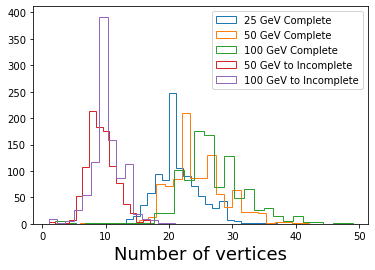

In [12]:
plt.hist(comNVertices25,histtype='step',bins=30,label="25 GeV Complete")
plt.hist(comNVertices50,histtype='step',bins=30,label="50 GeV Complete")
plt.hist(comNVertices100,histtype='step',bins=30,label="100 GeV Complete")
plt.hist(incNVertices,histtype='step',bins=15,label="50 GeV to Incomplete")
plt.hist(incNVertices100,histtype='step',bins=15,label="100 GeV to Incomplete")
plt.xlabel("Number of vertices",fontsize=18)
plt.legend()

In [38]:

comCenProfArray=[]
comNVerticesList=[]
N=200
for evt in range(N):
    print(evt)
    for tr in range(min(len(vertices_indexes[evt]),2)):
        #print(tr)
        if(evt==121 and tr==1):
            continue
        v_layers=vertices_layers[evt][tr]
        v_ind=vertices_indexes[evt][tr]
        v_x=vertices_x[evt][tr]
        v_y=vertices_y[evt][tr]
        v_z=vertices_z[evt][tr]
        v_E=vertices_E[evt][tr]
        TrNet=Network(vertices_indexes[evt,tr],vertices_x[evt,tr],vertices_y[evt,tr],
                                 vertices_z[evt,tr],vertices_E[evt,tr])
        TrNet.setWtMode(3)
        edges_1 = TrNet.edgeBuilderNew()
        edges_1 = ak.flatten(edges_1[ak.num(edges_1) > 0].to_list())
        TrNet.calcWeights(v_ind,edges_1,3)
        adjMatrix=TrNet.adjM(vertices_indexes[evt,tr],edges_1)
        c_nxkatz_undir=TrNet.nXCentralityPageRank(vertices_indexes[evt,tr],edges_1,False)
        
        cenProfList=TrNet.centralityProf(adjMatrix,c_nxkatz_undir)
        comCenProfArray.append(cenProfList)
        comNVerticesList.append(len(v_ind))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


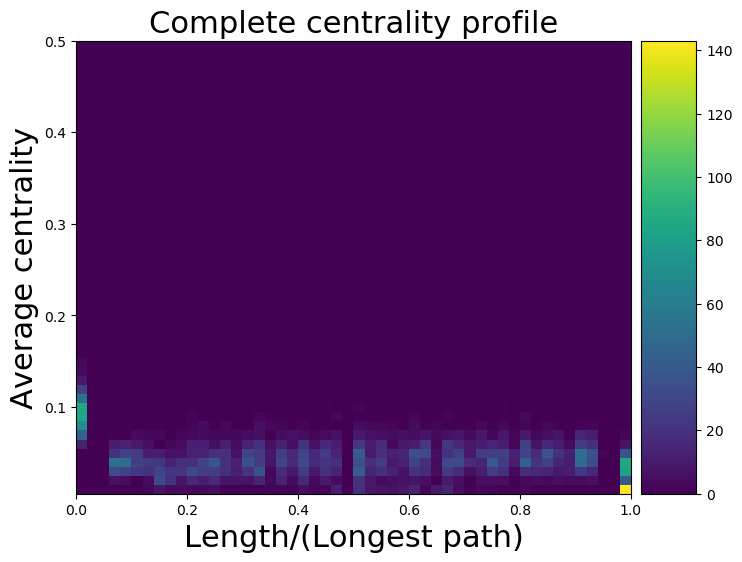

In [39]:


xValues=[]
#print(len(comCenProfArray))
for i in range(len(comCenProfArray)):
    xValues.append(np.arange(0,(len(comCenProfArray[i])))/(len(comCenProfArray[i])-1))
#print(xValues)
heatmap, xedges, yedges = np.histogram2d([x for xs in xValues for x in xs]
                                         ,[x for xs in comCenProfArray for x in xs],bins=50)

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
fig=plt.figure(figsize=(8,6),dpi=100)
ax=plt.gca()
im=ax.imshow(heatmap.T, extent=extent, origin='lower', aspect='auto')
plt.title("Complete centrality profile",fontsize=22)
plt.xlabel("Length/(Longest path)",fontsize=22)
plt.ylabel("Average centrality",fontsize=22)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.1)
   
plt.colorbar(im, cax=cax)
plt.show()
#plt.(np.arange(1,len(comCenProfArray[i])+1)/comNVerticesList[i],comCenProfArray[i])


In [20]:

incCenProfArray=[]
incNVerticesList=[]
incEnergies=[]
N=500

for evt in range(N):
    for tr in range(min(len(vertices_indexes_50[evt]),2)):
        #incSlice=fn.incompleteTracksters(vertices_layers_50[evt,tr],0.32,0.002)
        incSlice=fn.incompleteTracksters(vertices_layers_50[evt,tr],0.31,0.01)
        #print(incSlice)
        v_ind_inc=vertices_indexes_50[evt,tr][incSlice]
        v_x_inc=vertices_x_50[evt,tr][incSlice]
        v_y_inc=vertices_y_50[evt,tr][incSlice]
        v_z_inc=vertices_z_50[evt,tr][incSlice]
        v_E_inc=vertices_E_50[evt,tr][incSlice]
        incEnergies.append(ak.sum(v_E_inc))
        if(len(v_ind_inc)<2):
            continue
        TrNet=Network(v_ind_inc,v_x_inc,v_y_inc,v_z_inc,v_E_inc)
        TrNet.setWtMode(2)
        edges_1 = TrNet.edgeBuilderNew()
        edges_1 = ak.flatten(edges_1[ak.num(edges_1) > 0].to_list())
        #c_nxpr_undir=TrNet.nXCentralityPageRank(v_ind_inc,edges_1,0.85,False)
        #c_pr_undir=TrNet.centralityPageRank(v_ind_inc,edges_1,0.85,False)
        c_nx_katz_undir=TrNet.nXCentralityKatz(v_ind_inc,edges_1,False)
        #c_nx_eigen_undir=TrNet.nXCentralityEigen(vertices_indexes_com_g[tr],edges_1,False)
        #i_cen_max=np.argmax(c_pr_undir)
        adjMatrix=TrNet.adjM(v_ind_inc,edges_1)

        cenProfList=TrNet.centralityProf(adjMatrix,c_nx_katz_undir)
        incCenProfArray.append(cenProfList)
        incNVerticesList.append(len(v_ind_inc))
        if(len(cenProfList)>len(v_ind_inc)):
            print(cenProfList)
            print(len(v_ind_inc))
            print(evt,tr)
            print(v_ind_inc)
            print(edges_1)
        #print(len(incCenProfArray[i]))
        #print(incNVerticesList[i]-1)



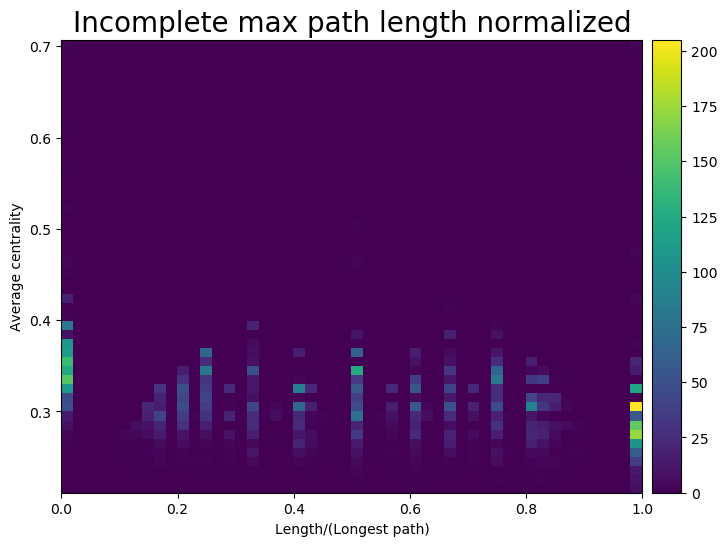

In [21]:


xValues=[]
#print(len(comCenProfArray))
for i in range(len(incCenProfArray)):
    xValues.append(np.arange(0,(len(incCenProfArray[i])))/(len(incCenProfArray[i])-1))
#print(xValues)
heatmap, xedges, yedges = np.histogram2d([x for xs in xValues for x in xs]
                                         ,[x for xs in incCenProfArray for x in xs],bins=50)

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
fig=plt.figure(figsize=(8,6),dpi=100)
plt.clf()
ax=plt.gca()
im=ax.imshow(heatmap.T, extent=extent, origin='lower',aspect='auto')
plt.title("Incomplete max path length normalized",fontsize=20)
plt.xlabel("Length/(Longest path)")
plt.ylabel("Average centrality")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
   
plt.colorbar(im, cax=cax)
plt.show()
#plt.(np.arange(1,len(comCenProfArray[i])+1)/comNVerticesList[i],comCenProfArray[i])


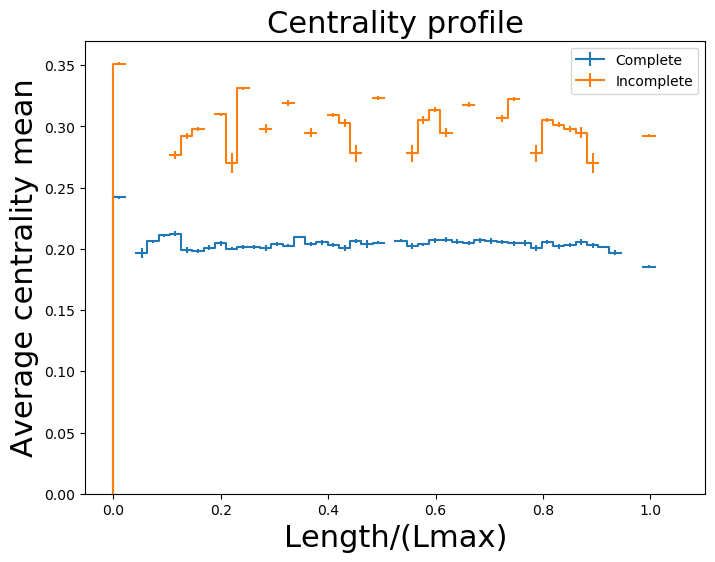

In [22]:


xValues=[]
#print(len(comCenProfArray))
for i in range(len(comCenProfArray[:500])):
    xValues.append(np.arange(0,(len(comCenProfArray[:500][i])))/(len(comCenProfArray[:500][i])-1))

hCom_xy = hist.Hist(
    hist.axis.Regular(50, 0, 1.05, name="x",overflow="False"), hist.axis.Regular(50, 0, 1, name="y")
).fill(x=[x for xs in xValues for x in xs],y=[x for xs in comCenProfArray[:500] for x in xs])
hpCom = hCom_xy.profile("y")


xValues=[]
#print(len(comCenProfArray))
for i in range(len(incCenProfArray)):
    xValues.append(np.arange(0,(len(incCenProfArray[i])))/(len(incCenProfArray[i])-1))

hInc_xy = hist.Hist(
    hist.axis.Regular(50, 0, 1.05, name="x",overflow="False"), hist.axis.Regular(50, 0, 1, name="y")
).fill(x=[x for xs in xValues for x in xs],y=[x for xs in incCenProfArray for x in xs])
#print(h_xy)
hpInc = hInc_xy.profile("y")

fig=plt.figure(figsize=(8,6),dpi=100)
hpCom.plot(label='Complete')
hpInc.plot(label='Incomplete')
plt.title("Centrality profile",fontsize=22)
plt.xlabel("Length/(Lmax)",fontsize=22)
plt.ylabel("Average centrality mean",fontsize=22)
plt.legend()
plt.show()

[0.    0.021 0.042 0.063 0.084 0.105 0.126 0.147 0.168 0.189 0.21  0.231
 0.252 0.273 0.294 0.315 0.336 0.357 0.378 0.399 0.42  0.441 0.462 0.483
 0.504 0.525 0.546 0.567 0.588 0.609 0.63  0.651 0.672 0.693 0.714 0.735
 0.756 0.777 0.798 0.819 0.84  0.861 0.882 0.903 0.924 0.945 0.966 0.987
 1.008 1.029 1.05 ] [0.24228           nan 0.19666667 0.20619469 0.21128655 0.21244444
 0.19931034 0.19837989 0.20104762 0.20456522 0.20025974 0.20123288
 0.20142857 0.20095238 0.204      0.20272727 0.21       0.20415205
 0.20526316 0.20312821 0.2008     0.20633028 0.20411765 0.20494071
        nan 0.2068254  0.20222222 0.20361111 0.2072043  0.20747899
 0.20596899 0.20442424 0.20714286 0.20631579 0.20545455 0.20448276
 0.20480519 0.20076923 0.20571429 0.20211538 0.20338983 0.20559322
 0.20278689 0.20153285 0.19701754        nan        nan 0.18548
        nan        nan]
50 50
[0.24228    0.19666667 0.20619469 0.21128655 0.21244444 0.19931034
 0.19837989 0.20104762 0.20456522 0.20025974 0.20123288 0.

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


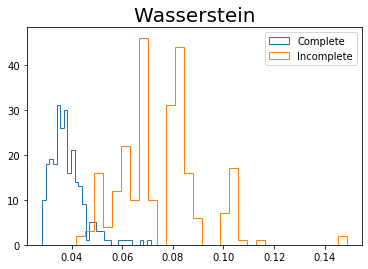

In [23]:
incWassenstein=[]
comWassenstein=[]

comProfileY,comProfileXEdges =hpCom.to_numpy()
#comProfileXClearn=comProfileX
print(comProfileXEdges,comProfileY)
comProfileX=[(comProfileXEdges[i]+comProfileXEdges[i+1])/2 for i in range(len(comProfileXEdges)-1)]
print(len(comProfileX),len(comProfileY))

comProfileYFixed=comProfileY[comProfileY > 0]
comProfileX=np.asarray(comProfileX)[comProfileY>0]
print(comProfileYFixed,comProfileX)
for i in range(250):
    incV=np.arange(0,(len(incCenProfArray[i])))/(len(incCenProfArray[i])-1)
    incWasserstein=scipy.stats.wasserstein_distance(comProfileX,incV
                                                 ,u_weights=comProfileYFixed,v_weights=incCenProfArray[i])
    #print(wassenstein)
    incWassenstein.append(incWasserstein)
    
    comV=np.arange(0,(len(comCenProfArray[500:][i])))/(len(comCenProfArray[500:][i])-1)
    comWasserstein=scipy.stats.wasserstein_distance(comProfileX,comV
                                                 ,u_weights=comProfileYFixed,v_weights=comCenProfArray[500:][i])
    #print(wassenstein)
    comWassenstein.append(comWasserstein)


plt.title("Wasserstein",fontsize=20)
plt.hist(comWassenstein,histtype="step",bins=30,label="Complete")
plt.hist(incWassenstein,histtype="step",bins=30,label="Incomplete")
plt.legend()